<a href="https://colab.research.google.com/github/vaishnavijohari/Automated-Answer-Evaluation-System/blob/main/Final_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %tensorflow_version 2.x
# import tensorflow as tf
# print("Tensorflow version " + tf.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

import tensorflow as tf
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.89.50.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.89.50.130:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
# Download the data
!wget https://s3.amazonaws.com/ps.public.resources/ml-showcase/news_summary.csv
!wget https://s3.amazonaws.com/ps.public.resources/ml-showcase/news_summary_more.csv

--2022-06-26 10:29:11--  https://s3.amazonaws.com/ps.public.resources/ml-showcase/news_summary.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.45.0
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.45.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11896415 (11M) [text/csv]
Saving to: ‘news_summary.csv’

news_summary.csv    100%[===================>]  11.34M  38.2MB/s    in 0.3s    

2022-06-26 10:29:12 (38.2 MB/s) - ‘news_summary.csv’ saved [11896415/11896415]

--2022-06-26 10:29:12--  https://s3.amazonaws.com/ps.public.resources/ml-showcase/news_summary_more.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.45.0
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.45.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41399270 (39M) [text/csv]
Saving to: ‘news_summary_more.csv’

news_summary_more.c 100%[===================>]  39.48M  55.8MB/s    in 0.7s    

2022-06-26 10:29:13 (55.8 MB/s) - ‘news_su

In [ ]:
# Install necessary libraries
# Note: You may need to restart your kernel!
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm
!pip install pandas
!pip3 install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 5.5 MB/s 
     |████████████████████████████████| 1.2 MB 45.7 MB/s 
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successfully uninstalled setuptools-57.4.0
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 62.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import tensorflow as tf
device_name = tf.test.gpu_device_name()

summary = pd.read_csv('news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
pre1 =  raw.iloc[:, 0:2].copy()
pre2 = summary.iloc[:, 0:6].copy()

# To increase the intake of possible text values to build a reliable model
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep = " "),sep = " "), sep = " ")

pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'],pre2['headlines']], ignore_index = True)

In [ ]:
pre.head(2)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...


In [ ]:
import re

# Remove non-alphabetic characters (Data Cleaning)
def text_strip(column):
    
    for row in column:        
        row = re.sub("(\\t)", ' ', str(row)).lower() 
        row = re.sub("(\\r)", ' ', str(row)).lower() 
        row = re.sub("(\\n)", ' ', str(row)).lower()
        
        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", ' ', str(row)).lower()   
        
        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", ' ', str(row)).lower()
        
        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", ' ', str(row)).lower()   
        
        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", ' ', str(row)).lower()   
        
        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", ' ', str(row)).lower()   
        
        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() 
        
        # Remove mailto:
        row = re.sub("(mailto:)", ' ', str(row)).lower() 
        
        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", ' ', str(row)).lower() 
        
        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() 
        
        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() 
        
        # Remove punctuations at the end of a word 
        row = re.sub("(\.\s+)", ' ', str(row)).lower() 
        row = re.sub("(\-\s+)", ' ', str(row)).lower() 
        row = re.sub("(\:\s+)", ' ', str(row)).lower() 
                
        # Replace any url to only the domain name
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass 
        
        # Remove multiple spaces
        row = re.sub("(\s+)",' ',str(row)).lower() 
        
        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", ' ', str(row)).lower() 
        
        yield row

In [ ]:


processed_text = text_strip(pre['text'])
processed_summary = text_strip(pre['summary'])

In [ ]:
import spacy
from time import time

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

# Process text as batches and yield Doc objects in order
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=5)]

summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=5)]

In [ ]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [ ]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

In [ ]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)
print(pre['cleaned_text'])

0         saurav kant an alumnus of upgrad and iiit-b pg...
1         kunal shah credit card bill payment platform c...
2         new zealand defeated india by wickets in the f...
3         with aegon life iterm insurance plan customers...
4         speaking about the sexual harassment allegatio...
                                ...                        
102910    mansha mahajan 24 feb 2017 friday indiatoday.i...
102911    dishant sharma 03 aug 2017 thursday indiatoday...
102912    tanya dhingra 03 aug 2017 thursday www.hindust...
102913    pragya swastik 07 dec 2016 wednesday indiatoda...
102914    chhavi tyagi 03 aug 2017 thursday indiatoday.i...
Name: cleaned_text, Length: 102915, dtype: object


In [ ]:
text_count = []
summary_count = []

In [ ]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [ ]:
graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

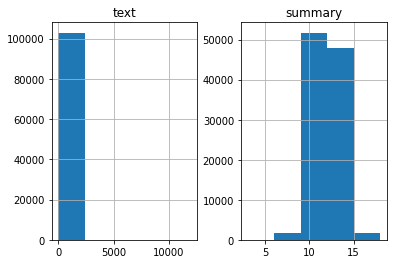

In [ ]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [ ]:
# Check how much % of text have 0-100 words
cnt = 0
for i in pre['cleaned_text']:
    if len(i.split()) <= 100:
        cnt = cnt + 1
print(cnt / len(pre['cleaned_text']))

0.9578389933440218


In [ ]:
# Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len = 100
max_summary_len = 15

In [ ]:
# Select the Summaries and Text which fall below max length 
import numpy as np

cleaned_text = np.array(pre['cleaned_text'])
cleaned_summary= np.array(pre['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

In [ ]:
post_pre.head(2)

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...


In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']), test_size=0.1, random_state=0, shuffle=True)

In [ ]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ",(cnt / tot_cnt) * 100)

% of rare words in vocabulary:  62.625791318822664


In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 29638


In [ ]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

% of rare words in vocabulary: 62.56031626068251


In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = y_tokenizer.num_words + 1

print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 12881


In [ ]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []

for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [ ]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

latent_dim = 300
embedding_dim = 200

# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     5927600     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
# Note: this will take a while. Run as many epochs as needed.
with tf.device(device_name):
  history = model.fit([x_tr, y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:], epochs=10, callbacks=[es], batch_size=128, validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Epoch 1/10
692/692 [==============================] - 696s 1s/step - loss: 4.6378 - val_loss: 4.4463
Epoch 2/10
692/692 [==============================] - 697s 1s/step - loss: 4.3655 - val_loss: 4.2167
Epoch 3/10
692/692 [==============================] - 697s 1s/step - loss: 4.1471 - val_loss: 4.0426
Epoch 4/10
692/692 [==============================] - 698s 1s/step - loss: 3.9897 - val_loss: 3.9226
Epoch 5/10
692/692 [==============================] - 697s 1s/step - loss: 3.8634 - val_loss: 3.8298
Epoch 6/10
692/692 [==============================] - 698s 1s/step - loss: 3.7577 - val_loss: 3.7603
Epoch 7/10
692/692 [==============================] - 699s 1s/step - loss: 3.6702 - val_loss: 3.7026
Epoch 8/10
692/692 [==============================] - 699s 1s/step - loss: 3.5901 - val_loss: 3.6479
Epoch 9/10
692/692 [==============================] - 700s 1s/step - loss: 3.5187 - val_loss: 3.6040
Epoch 10/10
692/692 [==============================] - 699s 1s/step - loss: 3.4561 - val_lo

In [ ]:
!mkdir -p saved_model
with tf.device(device_name):
  model.save('saved_model/saved_summarizer.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('saved_model/saved_summarizer.h5')
print(loaded_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 200)     5927600     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 100, 300),   601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

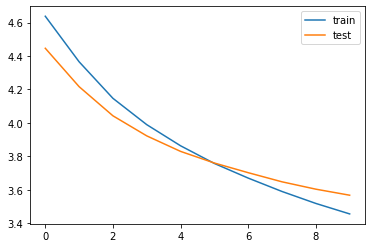

In [ ]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token != 'end'):
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['start'] and i \
            != target_word_index['end']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString

In [ ]:
predicted_summary = []
original_summary = []
prediction_data_length = 19
for i in range(0, prediction_data_length):
    print("Review:", seq2text(x_tr[i]))
    original = seq2summary(y_tr[i])
    original_summary.append(original)
    print("Original summary:", original)
    prediction = decode_sequence(x_tr[i].reshape(1, max_text_len))
    predicted_summary.append(prediction)
    print("Predicted summary:", prediction)
    print("\n")

Review: lok janshakti party president ram vilas paswan daughter asha has said she will contest elections against him from constituency if given ticket from lalu prasad yadav rjd she accused him of neglecting her and promoting his son chirag asha is paswan daughter from his first wife while chirag is his son from his second wife 
Original summary: will contest against father ram vilas from daughter 
Predicted summary:  will be son of son son to join son son


Review: irish deputy prime minister frances fitzgerald announced her resignation on tuesday in bid to avoid the collapse of the government and potential snap election she quit hours before no confidence motion was to be proposed against her by the main opposition party the political crisis began over fitzgerald role in police whistleblower scandal 
Original summary: irish deputy prime minister resigns to avoid govt collapse 
Predicted summary:  pm modi to be removed from parliament


Review: rr wicketkeeper batsman jos buttler slam

In [ ]:
# classification model

In [ ]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)

In [ ]:
print(twenty_train.target_names) #prints all the categories
print("\n".join(twenty_train.data[0].split("\n")[:])) #prints first data
for i in range(len(twenty_train.data)):
  data = list(twenty_train.data[i].split("\n"))
  for j in range(len(data)):
    if data[j].find(':') == -1:
      twenty_train.data[i] = "\n".join(data[j:])
      break
print("\n".join(twenty_train.data[0].split("\n")[:])) #prints updated first data

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have o

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape


(11314, 125403)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(11314, 125403)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

In [ ]:
>>> from sklearn.pipeline import Pipeline
>>> text_clf = Pipeline([('vect', CountVectorizer()),
...                      ('tfidf', TfidfTransformer()),
...                      ('clf', MultinomialNB()),
... ])
text_clf = text_clf.fit(twenty_train.data, twenty_train.target)

In [ ]:
import numpy as np
# twenty_test = fetch_20newsgroups(subset='test', shuffle=True)
# for i in range(len(twenty_test.data)):
#   data = list(twenty_test.data[i].split("\n"))
#   for j in range(len(data)):
#     if data[j].find(':') == -1:
#       twenty_test.data[i] = "\n".join(data[j:])
#       break
# print(twenty_test.data[0])

predicted_class = text_clf.predict(predicted_summary)
original_class = text_clf.predict(original_summary)
for i in range(0, prediction_data_length):
  print("predicted class for sample no. ", i, ": ", twenty_train.target_names[predicted_class[i]])
  print("original class for sample no.  ", i, ": ", twenty_train.target_names[original_class[i]])
  print()

predicted class for sample no.  0 :  soc.religion.christian
original class for sample no.   0 :  soc.religion.christian

predicted class for sample no.  1 :  talk.politics.mideast
original class for sample no.   1 :  talk.politics.mideast

predicted class for sample no.  2 :  rec.sport.hockey
original class for sample no.   2 :  rec.sport.hockey

predicted class for sample no.  3 :  rec.motorcycles
original class for sample no.   3 :  sci.crypt

predicted class for sample no.  4 :  rec.autos
original class for sample no.   4 :  rec.autos

predicted class for sample no.  5 :  talk.politics.mideast
original class for sample no.   5 :  talk.politics.mideast

predicted class for sample no.  6 :  soc.religion.christian
original class for sample no.   6 :  sci.med

predicted class for sample no.  7 :  sci.space
original class for sample no.   7 :  sci.electronics

predicted class for sample no.  8 :  sci.crypt
original class for sample no.   8 :  talk.politics.mideast

predicted class for sa

In [ ]:
!pip install -U sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
model = SentenceTransformer('bert-base-nli-mean-tokens')
def getSimilarity(sen):
  sen_embeddings = model.encode(sen)
  return cosine_similarity([sen_embeddings[0]], sen_embeddings[1:])

for i in range(0, prediction_data_length):
  if (twenty_train.target_names[predicted_class[i]] == twenty_train.target_names[original_class[i]]):
    print("Teacher's and Student's answers matched with class: ", twenty_train.target_names[predicted_class[i]])
    print("Score: ", int(getSimilarity([predicted_summary[i], original_summary[i]])[0][0]*100), "/100")
  else:
    print("Student's and teacher's answer didn't match with same class")
    print("Score: ", int(getSimilarity([predicted_summary[i], original_summary[i]])[0][0]*100), "/100")

  print()

Teacher's and Student's answers matched with class:  soc.religion.christian
Score:  54 /100

Teacher's and Student's answers matched with class:  talk.politics.mideast
Score:  66 /100

Teacher's and Student's answers matched with class:  rec.sport.hockey
Score:  57 /100

Student's and teacher's answer didn't match with same class
Score:  64 /100

Teacher's and Student's answers matched with class:  rec.autos
Score:  50 /100

Teacher's and Student's answers matched with class:  talk.politics.mideast
Score:  59 /100

Student's and teacher's answer didn't match with same class
Score:  46 /100

Student's and teacher's answer didn't match with same class
Score:  58 /100

Student's and teacher's answer didn't match with same class
Score:  40 /100

Teacher's and Student's answers matched with class:  talk.politics.guns
Score:  75 /100

Student's and teacher's answer didn't match with same class
Score:  45 /100

Teacher's and Student's answers matched with class:  soc.religion.christian
Score: